# Scanning CVEs for git-based commit URLs

In [52]:
import urllib.request
from unidiff import PatchSet
import os
import pandas as pd 
import seaborn as sns
import json
from pandas import json_normalize
from tabulate import tabulate 
import glob
# time of execution
import time
from pathlib import Path

DIR = 'cvelistV5-main/cves/2024/0xxx'

# check if the directory exists using pathlib othwerwise create it
Path('figure').mkdir(parents=True, exist_ok=True)

In [53]:
import os 

def find_json_files(directory):
    """Find all JSON files in the given directory (including subdirectories).
    """
    json_files = glob.glob(os.path.join(directory, '**/*.json'), recursive=True)
    return json_files

def find_commit_urls(urls):
    """collect all the URLs of they are commit hashes
    """
    commit_urls = [url for url in urls if 'commit' in url]
    return commit_urls

def find_urls(json_files):
    """collect all the URLs from the CVE Json files
    """
    patch_links = {}

    if json_files:
        # print(f"JSON files found: {len(json_files)}")
        for json_file in json_files:
            if os.path.isfile(json_file):
                try:
                    # with open(json_file, 'r') as f:
                    df = pd.read_json(json_file)
                    refs = df.containers.cna['references']
                    urls = [ref['url'] for ref in refs if 'url' in ref]
                    commit_urls = find_commit_urls(urls)

                    if commit_urls:
                        patch_links[json_file] = commit_urls
                    
                except Exception as exec:
                    print(f'Error reading JSON file {json_file}: {exec}')

    else:
        print("No JSON file found in the directory.")
    return patch_links 

if not os.path.isdir(DIR):
    print("Invalid directory path.")
    exit(2)

json_files = find_json_files(DIR)
patch_links = find_urls(json_files)
print(f'Number of URL links: {len(patch_links)}')
# [x  for x in urls if 'github' in x]

Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0069.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0070.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0228.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0393.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0395.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0663.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0694.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0704.json: 'references'
Error reading JSON file cvelistV5-main/cves/2024/0xxx/CVE-2024-0706.json: 'references'
Number of URL links: 14


In [54]:
def map_rename(columns):
    """Create a renaming mapping dictionary
    """
    rename_mapping = {}
    for key in columns:
        # if key.startswith('containers.cna.affected'):
        #     rename_mapping[key] = 'affected_' + key.split('.')[-1]
        # elif key.startswith('containers.cna.credits'):
        #     rename_mapping[key] = 'credits_' + key.split('.')[-1]
        # elif key.startswith('containers.cna.descriptions'):
        #     rename_mapping[key] = 'desc_' + key.split('.')[-1]
        # elif key.startswith('containers.cna.metrics'):
        #     rename_mapping[key] = 'metrics_' + key.split('.')[-1]
        # problemType: CWE types
        # elif key.startswith('containers.cna.problemTypes'):
        #     rename_mapping[key] = 'problem_' + key.split('.')[-1]
        # elif key.startswith('containers.cna.providerMetadata'):
        #     rename_mapping[key] = 'provider_' + key.split('.')[-1]
        # elif key.startswith('containers.cna.solutions'):
        #     rename_mapping[key] = 'solution_' + key.split('.')[-1]
        # elif key.startswith('containers.cna.source.'):
        #     rename_mapping[key] = 'solution_' + key.split('.')[-1]
        # else:
        rename_mapping[key] = (key.split('.')[-1])
    return rename_mapping


# json_file = 'cvelistV5-main/cves/2024/21xxx/CVE-2024-21309.json'

def json2df(json_file):
    """Convert JSON data to a pandas DataFrame
    """
    # Read JSON data from file
    with open(json_file, 'r') as f:
        json_data = json.load(f)
        
    df = json_normalize(json_data, max_level=5)
    df = df.rename(columns=map_rename(df.columns))
    return df

# function to merge all json files into a single dataframe
def merge_json_files(json_files):
    """Merge all the JSON files into a single DataFrame
    """
    # totoal number of json files
    print('='*20 + 'Merging JSON files' + '='*20)
    print(f'#JSON files to scan: {len(json_files)}')
    print('='*40)
    df = pd.DataFrame()
    for json_file in json_files:
        try:
            df_json = json2df(json_file)
            # dfs = [json2df(json_file) for json_file in json_files]
            # print(f'Number of DataFrames: {len(dfs)}')
            # try:
            if 'cveId' in list(df_json.columns):
                if df.empty:
                    df = df_json
                else:
                    unique_cols = list(set(list(df.columns) + list(df_json.columns)))
                    # insert new columns with None values
                    for column in unique_cols:
                        if column not in list(df.columns):
                            df[column] = None
                        if column not in list(df_json.columns):
                            df_json[column] = None

                    df= df.sort_index(axis=1)
                    df_json= df_json.sort_index(axis=1)

                    df = pd.concat([df, df_json], ignore_index=True, sort=False)
                # print('='*20)
            # verbose how many files have been processed
            if len(df) % 500 == 0:
                print(f'#files scanned: {len(df)}')
                print('='*40)
        

        except Exception as exec:
            print(f'Error: {exec}')
            print(f'Error reading file: {json_file}')
            continue
    print(f'Number of DataFrames: {len(df)}')
    return df

# df = json2df('cvelistV5-main/cves/2016/1xxx/CVE-2016-1587.json')
# df
json_files = list(patch_links.keys())

df = merge_json_files(json_files)
# print(f'Shape of the dataframe: {df.shape}')
# # show tabulated data
# print(tabulate(df.head(), headers='keys', tablefmt='psql'))


====================Merging JSON files====================
#JSON files to scan: 14
Number of DataFrames: 14


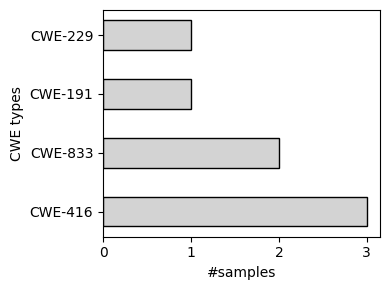

In [66]:
# TODO: plot the value counts of the cwe types
cwe = df.x_redhatCweChain.str.split(':', expand=True)[0]
vals = cwe.value_counts()

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(vals.index, vals.values, color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('CWE types')
ax.set_xlabel('#samples')
plt.tight_layout()

plt.savefig(f'figure/CWE-types.png')
plt.show()


In [68]:
# function to describe df.afftected
# def describe_affected(row):
#     if row:
#         # print(tabulate(json_normalize(row), headers='keys', tablefmt='psql'))
#         for x in row:
#             if isinstance(x, dict):
#                 for key in x.keys():
#                     print(f'{key}: {x[key]}')
#                     if isinstance(x[key], dict):
#                         for item in x[key]:
#                             print(f'{item}: {x[key][item]}')
#                 print('\n')

def normalize_list_column(df, column):
    """Normalize a column containing lists
    put all the data into a single dataframe of all column value list
    """
    df_col = pd.DataFrame()
    for index, row in df.iterrows():
        if row[column]:
            df_part  = json_normalize(row[column])
            df_part['cveId'] = row['cveId']
            df_col = pd.concat([df_col, df_part], ignore_index=True)
    return df_col

# Check which columns contain lists
columns_with_lists = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, list)).any()]
print(f'Columns with list type: \n{columns_with_lists}\n')


# Normalize the columns with lists
# put all dataframes into a single dictionary
col_dfs = {}

for col in columns_with_lists:
    col_dfs[col] = normalize_list_column(df, column=col)
    # print(tabulate(df_part, headers='keys', tablefmt='psql'))
    print(f'Table: {col} - {col_dfs[col].shape}')

Columns with list type: 
['affected', 'credits', 'descriptions', 'impacts', 'metrics', 'problemTypes', 'references', 'timeline', 'workarounds']

Table: affected - (81, 8)
Table: credits - (4, 5)
Table: descriptions - (14, 4)
Table: impacts - (1, 3)
Table: metrics - (21, 31)
Table: problemTypes - (13, 2)
Table: references - (43, 4)
Table: timeline - (16, 4)
Table: workarounds - (8, 3)


# Parsing git patch from commit $hash.diff$

In [69]:

def get_patch_from_url(url):
    """retrieve patch from the given git-based commit URL.
    """
    url_diff = url + '.diff'
    # diff = urllib.request.urlopen('https://github.com/ASSERT-KTH/RewardRepair/commit/2509b5e91e2e80b6b84da3d8cd0e1d1748c0ecfc.diff')
    diff = urllib.request.urlopen(url_diff)
    encoding = diff.headers.get_charsets()[0]
    patch = PatchSet(diff, encoding=encoding)
    return patch 

def get_language_from_ext(file_path):
    extension = file_path.split('.')[-1].lower()
    language_mapping = {
        'c': 'C',
        'h': 'C',
        'cpp': 'C++',
        'hpp': 'C++',
        'java': 'Java',
        'py': 'Python',
        'js': 'JavaScript',
        'html': 'HTML',   # Markup language, not a programming language
        'htm': 'HTML',
        'css': 'CSS',     # Style sheet language, not a programming language
        'php': 'PHP',
        'rb': 'Ruby',
        'swift': 'Swift',
        'cs': 'C#',
        'vb': 'Visual Basic',
        'go': 'Go',
        'rust': 'Rust',
        'ts': 'TypeScript',
        'dart': 'Dart',
        'pl': 'Perl',
        'lua': 'Lua',
        'sh': 'Shell script',
        'ps1': 'PowerShell script',
        'jsx': 'JSX',     # JavaScript extension used with React
        'tsx': 'TypeScript with JSX',  # Used with React
        'r': 'R',
        'scala': 'Scala',
        'jl': 'Julia',
        'matlab': 'MATLAB',
        'asm': 'Assembly',
        'sql': 'SQL',     # Query language, not a programming language
        'kt': 'Kotlin',
        'vue': 'Vuejs',  # JavaScript framework
        'scss': 'SASS',   # CSS preprocessor
        'sass': 'SASS'
    }
    return language_mapping.get(extension, 'Unknown')

def parse_patch(patch):
    """parse patch and convert it into dataframe
    """
    # Access information about each file in the patchset
    data = {'file': [], 'removed': [], 'added': [], 'unchanged':[], 'pl':[]}

    for patched_file in patch:
        for hunk in patched_file:
            added_lines = []
            removed_lines = []
            unchanged_lines = []

            for line in hunk:
                if line.is_added:
                    added_lines.append(line.value.strip())
                elif line.is_removed:
                    removed_lines.append(line.value.strip())
                else:
                    unchanged_lines.append(line.value.strip())
            
            data['file'].append(patched_file.path)
            data['added'].append('\n'.join(added_lines))
            data['removed'].append('\n'.join(removed_lines))
            data['unchanged'].append('\n'.join(unchanged_lines))
            data['pl'].append(get_language_from_ext(patched_file.path))
    return data


def collect_patches(github_urls):
    """collect patches of the given URLs
    """
    df  = pd.DataFrame()
    for url in github_urls:
        print(f'Scanning URL: {url}')
        try:
            patch = get_patch_from_url(url)
            data = parse_patch(patch)
            df_patch = pd.DataFrame(data)
            df_patch['url'] = url 

            if len(data)>0:
                df = pd.concat([df, df_patch])

        except Exception as exec:
            print(f'Error: {exec}')
    df = df.reset_index(drop=True)
    return df


# url = 'https://github.com/torvalds/linux/commit/3f24fcdacd40c70dd2949c1cfd8cc2e75942a9e3'
# patch = get_patch_from_url(url)

urls = list(col_dfs['references'].url)

github_urls = [url for url in urls if 'commit' in url]
df_patch = collect_patches(github_urls)
df_patch

Scanning URL: https://github.com/PackageKit/PackageKit/commit/64278c9127e3333342b56ead99556161f7e86f79
Scanning URL: https://github.com/stevegeek/encoded_id-rails/commit/afa495a77b8a21ad582611f9cdc2081dc4018b91
Scanning URL: https://github.com/gpac/gpac/commit/d0ced41651b279bb054eb6390751e2d4eb84819a
Scanning URL: https://github.com/gpac/gpac/commit/092904b80edbc4dce315684a59cc3184c45c1b70
Scanning URL: https://www.spinics.net/lists/stable-commits/msg328851.html
Error: HTTP Error 404: Not Found
Scanning URL: https://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git/commit/?id=c392cbecd8eca4c53f2bf508731257d9d0a21c2d
Error: HTTP Error 400: Bad request
Scanning URL: https://github.com/torvalds/linux/commit/c301f0981fdd3fd1ffac6836b423c4d7a8e0eb63
Scanning URL: https://github.com/torvalds/linux/commit/6feb37b3b06e9049e20dcf7e23998f92c9c5be9a
Scanning URL: https://github.com/torvalds/linux/commit/08e50cf071847323414df0835109b6f3560d44f5
Scanning URL: https://git.kernel.org/pub/scm

,file,removed,added,unchanged,pl,url
0,src/pk-transaction.c,,gboolean\t\t emitted_finished;,guint\t\t\t speed;\nguint\t\t\t download_size_...,C,https://github.com/PackageKit/PackageKit/commi...
1,src/pk-transaction.c,,g_assert (!transaction->priv->emitted_finished...,"PkExitEnum exit_enum,\nguint time_ms)\n{\ng_de...",C,https://github.com/PackageKit/PackageKit/commi...
2,encoded_id-rails.gemspec,"spec.add_dependency ""encoded_id"", ""~> 1.0.0.rc2""","spec.add_dependency ""encoded_id"", ""~> 1.0.0.rc3""",# Uncomment to register a new dependency of yo...,Unknown,https://github.com/stevegeek/encoded_id-rails/...
3,src/filters/load_text.c,,"if ( j >= lineSize ) {\nGF_LOG(GF_LOG_DEBUG, G...","GF_LOG(GF_LOG_DEBUG, GF_LOG_PARSER, (""[TXTIn] ...",C,https://github.com/gpac/gpac/commit/d0ced41651...
4,src/filters/reframe_ac3.c,if (!ctx->in_seek && remain >= ctx->hdr.frames...,if (!ctx->in_seek && remain >= sync_pos + ctx-...,cts = GF_FILTER_NO_TS;\n}\n\ndst_pck = gf_filt...,C,https://github.com/gpac/gpac/commit/092904b80e...
...,...,...,...,...,...,...
99,test/test_helpers.py,await asyncio.sleep(delay)\n\nlog_messages = [...,client = grc.Client(demo.local_url)\njob = cli...,demo.launch(prevent_thread_lock=True)\n\nasync...,Python,https://github.com/gradio-app/gradio/commit/d7...
100,test/test_queueing.py,demo.launch(prevent_thread_lock=True)\n,,"\nname.submit(greet, name, output)\n\nwith con...",Python,https://github.com/gradio-app/gradio/commit/d7...
101,test/test_queueing.py,time.sleep(2),time.sleep(4),"\n@add_btn.click(inputs=[a, b], outputs=output...",Python,https://github.com/gradio-app/gradio/commit/d7...
102,test/test_queueing.py,time.sleep(1),time.sleep(2),"add_job_2 = client.submit(1, 1, fn_index=0)\na...",Python,https://github.com/gradio-app/gradio/commit/d7...


## Plotting the distribution of programming languages

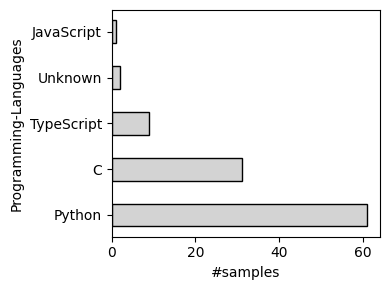

In [74]:
# plot_value_counts(col=df_patch['pl'], xlabel='Programming-Languages', ylabel='#patches')

pls = df_patch['pl'].value_counts()

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(pls.index, pls.values, color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('Programming-Languages')
ax.set_xlabel('#samples')
plt.tight_layout()
plt.savefig(f'figure/Programming-Languages.png')
plt.show()


# The function that counts the length of words in the values of a specified column in a DataFrame and plots the distribution as a histogram:

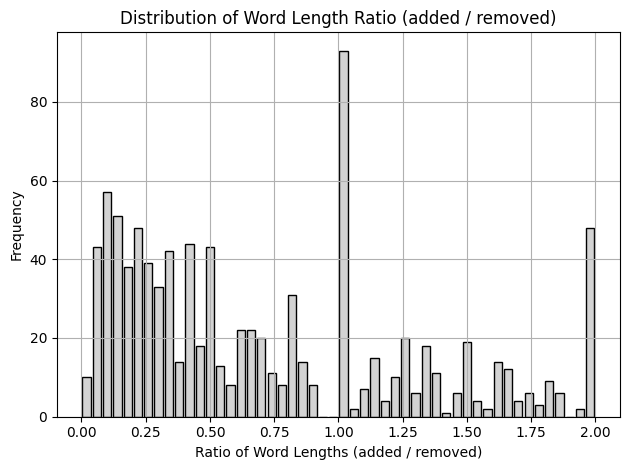

In [82]:
def count_and_plot_word_length_ratio(df, column1, column2):
    """
    Count the length of words in the values of two specified columns in a DataFrame,
    compute the ratio of corresponding word lengths, and plot the distribution as a histogram.

    Parameters:
        df (pandas DataFrame): The DataFrame containing the data.
        column1 (str): The name of the first column in the DataFrame to analyze.
        column2 (str): The name of the second column in the DataFrame to analyze.
    """
    # Extract values from the specified columns
    values1 = df[column1]
    values2 = df[column2]

    # Tokenize words and count lengths for both columns
    word_lengths1 = [len(word) for value in values1 for word in str(value).split()]
    word_lengths2 = [len(word) for value in values2 for word in str(value).split()]

    # Compute the ratio of word lengths
    word_length_ratio = [length2 / length1 if length1 != 0 else float('NaN') for length1, length2 in zip(word_lengths1, word_lengths2)]

    # Plot histogram
    plt.hist(word_length_ratio, bins=50, range=(0, 2), rwidth=0.8, color='lightgray', edgecolor='black')
    plt.xlabel('Ratio of Word Lengths (added / removed)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Word Length Ratio (added / removed)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figure/word-length-ratio.png')
    plt.show()
    return word_length_ratio

word_length_ratio = count_and_plot_word_length_ratio(df_patch, 'removed', 'added')

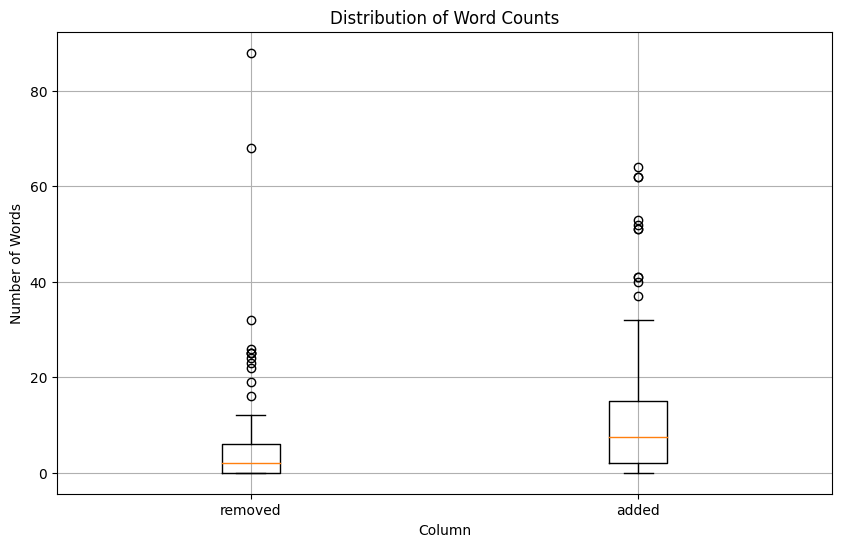

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def count_and_plot_word_lengths(df, column1, column2, outlier_threshold=0.95):
    """
    Count the number of words in the values of two specified columns in a DataFrame
    and plot the distributions as box plots side by side.

    Parameters:
        df (pandas DataFrame): The DataFrame containing the data.
        column1 (str): The name of the first column in the DataFrame to analyze.
        column2 (str): The name of the second column in the DataFrame to analyze.
        outlier_threshold (float): The threshold for identifying outliers (default is 0.95).
    """
    # Extract values from the specified columns
    values1 = df[column1]
    values2 = df[column2]

    # Count number of words for both columns
    word_counts1 = [len(str(value).split()) for value in values1]
    word_counts2 = [len(str(value).split()) for value in values2]

    # Identify outliers using quantiles
    max_outlier_count1 = np.quantile(word_counts1, outlier_threshold)
    max_outlier_count2 = np.quantile(word_counts2, outlier_threshold)

    # Filter out outliers
    filtered_word_counts1 = [count for count in word_counts1 if count <= max_outlier_count1]
    filtered_word_counts2 = [count for count in word_counts2 if count <= max_outlier_count2]

    # Create box plots side by side
    plt.figure(figsize=(10, 6))

    plt.boxplot([filtered_word_counts1, filtered_word_counts2], labels=[column1, column2])
    plt.xlabel('Column')
    plt.ylabel('Number of Words')
    plt.title('Distribution of Word Counts')
    plt.grid(True)
    plt.show()


# Call the function with the DataFrame and column names
count_and_plot_word_lengths(df_patch, 'removed', 'added')


In [ ]:
df_patch.url.value_counts()

url
https://github.com/gradio-app/gradio/commit/d76bcaaaf0734aaf49a680f94ea9d4d22a602e70                       71
https://github.com/openssl/openssl/commit/775acfdbd0c6af9ac855f34969cdab0c0c90844a                          6
https://github.com/openssl/openssl/commit/d135eeab8a5dbf72b3da5240bab9ddb7678dbd2c                          6
https://github.com/openssl/openssl/commit/09df4395b5071217b76dc7d3d2e630eb8c5a79c2                          6
https://github.com/torvalds/linux/commit/c301f0981fdd3fd1ffac6836b423c4d7a8e0eb63                           4
https://scm.linefinity.com/common/linux-stable/commit/4c0b4818b1f636bc96359f7817a2d8bab6370162              3
https://github.com/PackageKit/PackageKit/commit/64278c9127e3333342b56ead99556161f7e86f79                    2
https://github.com/stevegeek/encoded_id-rails/commit/afa495a77b8a21ad582611f9cdc2081dc4018b91               1
https://github.com/gpac/gpac/commit/d0ced41651b279bb054eb6390751e2d4eb84819a                                1
https:

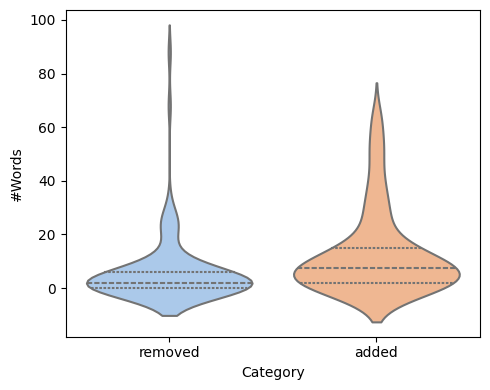

In [81]:
import pandas as pd
import seaborn as sns
import numpy as np

def count_and_plot_word_lengths(df, column1, column2, outlier_threshold=0.95):
    """
    Count the number of words in the values of two specified columns in a DataFrame
    and plot the distributions as violin plots side by side.

    Parameters:
        df (pandas DataFrame): The DataFrame containing the data.
        column1 (str): The name of the first column in the DataFrame to analyze.
        column2 (str): The name of the second column in the DataFrame to analyze.
        outlier_threshold (float): The threshold for identifying outliers (default is 0.95).
    """
    # Extract values from the specified columns
    values1 = df[column1]
    values2 = df[column2]

    # Count number of words for both columns
    word_counts1 = [len(str(value).split()) for value in values1]
    word_counts2 = [len(str(value).split()) for value in values2]

    # Identify outliers using quantiles
    max_outlier_count1 = np.quantile(word_counts1, outlier_threshold)
    max_outlier_count2 = np.quantile(word_counts2, outlier_threshold)

    # Filter out outliers
    filtered_word_counts1 = [count for count in word_counts1 if count <= max_outlier_count1]
    filtered_word_counts2 = [count for count in word_counts2 if count <= max_outlier_count2]

    # # Combine word counts from both columns
    # combined_word_counts = {'Category': [column1]*len(word_counts1) + [column2]*len(word_counts2),
    #                         '#Words': word_counts1 + word_counts2}
    
    # Combine word counts from both columns without outliers
    combined_word_counts = {'Category': [column1]*len(filtered_word_counts1) + [column2]*len(filtered_word_counts2),
                            '#Words': filtered_word_counts1 + filtered_word_counts2}

    # Create DataFrame from combined data
    combined_df = pd.DataFrame(combined_word_counts)

    # Plot violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(x='Category', y='#Words', data=combined_df, inner='quartile', hue='Category', palette='pastel', color='lightgray', linewidth=1.5, width=0.8)
    plt.xlabel('Category')
    plt.ylabel('#Words')
    # plt.title('Distribution of Word Counts')
    # plt.title(f'Distribution of Word Counts in {column2}')
    plt.tight_layout()
    plt.savefig(f'figure/word-counts-violin.png')
    plt.show()

# Call the function with the DataFrame and column names
count_and_plot_word_lengths(df_patch, 'removed', 'added')

In [ ]:
df_patch.url.value_counts()

url
https://github.com/gradio-app/gradio/commit/d76bcaaaf0734aaf49a680f94ea9d4d22a602e70                       71
https://github.com/openssl/openssl/commit/775acfdbd0c6af9ac855f34969cdab0c0c90844a                          6
https://github.com/openssl/openssl/commit/d135eeab8a5dbf72b3da5240bab9ddb7678dbd2c                          6
https://github.com/openssl/openssl/commit/09df4395b5071217b76dc7d3d2e630eb8c5a79c2                          6
https://github.com/torvalds/linux/commit/c301f0981fdd3fd1ffac6836b423c4d7a8e0eb63                           4
https://scm.linefinity.com/common/linux-stable/commit/4c0b4818b1f636bc96359f7817a2d8bab6370162              3
https://github.com/PackageKit/PackageKit/commit/64278c9127e3333342b56ead99556161f7e86f79                    2
https://github.com/stevegeek/encoded_id-rails/commit/afa495a77b8a21ad582611f9cdc2081dc4018b91               1
https://github.com/gpac/gpac/commit/d0ced41651b279bb054eb6390751e2d4eb84819a                                1
https:

# Save dataframes to csv files

In [ ]:
df_patch.to_csv('output/patches.csv', index=False)
df.to_csv('output/cve.csv', index=False)

for x in col_dfs:
    print(x, col_dfs[x].shape)
    # save to csv

    col_dfs[x].to_csv(f'output/{x}.csv', index=False)

affected (81, 8)
credits (4, 5)
descriptions (14, 4)
impacts (1, 3)
metrics (21, 31)
problemTypes (13, 2)
references (43, 4)
timeline (16, 4)
workarounds (8, 3)


[0 1 2 3]


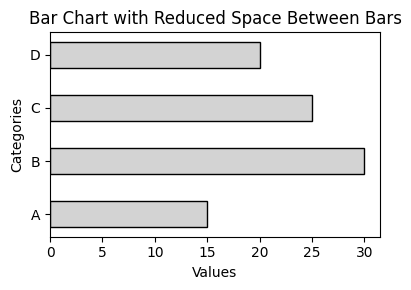

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['A', 'B', 'C', 'D']
values = [15, 30, 25, 20]

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5

# Calculate the position for each bar
x = np.arange(len(categories))

# Create bar chart with reduced space between bars
bars = ax.barh(x, values, color='lightgray', edgecolor='black', height=bar_width)

# Customize plot
ax.set_ylabel('Categories')
ax.set_xlabel('Values')
ax.set_title('Bar Chart with Reduced Space Between Bars')

# Set the x-axis tick positions and labels
ax.set_yticks(x)
ax.set_yticklabels(categories)

# Remove space between bars
plt.tight_layout()

# Show plot
plt.show()
